In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook

from keras.applications import VGG16
from keras.datasets import cifar10
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K

from cleverhans.attacks import FastGradientMethod, LBFGS
from cleverhans.utils_keras import KerasModelWrapper

from foolbox.attacks import SinglePixelAttack
from foolbox.models import KerasModel

Using TensorFlow backend.


In [14]:
def batches(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def grad_cam(model, img, label, conv_layer_idx, process=False, my_process=False):
    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)
    elif len(img.shape) != 4:
        raise ValueError('img not shape (1, w, h, 3)')
    
    class_output = model.output[:, label]
    last_conv_layer = model.layers[conv_layer_idx]
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print('Pooled grads:', pooled_grads.shape[0])
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(pooled_grads.shape[0]): # 512
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    if process:
        #print(heatmap.max())
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / heatmap.max()
        heatmap = cv2.resize(heatmap, (32, 32))
    elif my_process:
        heatmap = heatmap + abs(heatmap.min())
        heatmap = heatmap / heatmap.max()
        heatmap = cv2.resize(heatmap, (32, 32))
    
    return heatmap

def plot_pair(img, adv, model=None, cifar10=False):
    if len(img.shape) != 3 or len(adv.shape) != 3:
        raise ValueError("Image shape must have len 3")
    
    if model:
        img_pred = np.argmax(model.predict(np.expand_dims(img, axis=0)))
        adv_pred = np.argmax(model.predict(np.expand_dims(adv, axis=0)))
        if cifar10:
            img_pred = CIFAR10_LABEL_NAMES[img_pred]
            adv_pred = CIFAR10_LABEL_NAMES[adv_pred]
    
    diff = img - adv
    diff = diff + abs(diff.min())
    diff = diff / diff.max()
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 9))
    axs[0].imshow(img)
    axs[1].imshow(diff)
    axs[2].imshow(adv)
    
    if model:
        axs[0].set_title("Original Image" + "\nPred: " + str(img_pred))
        axs[1].set_title("Difference")
        axs[2].set_title("Adversarial Image" + "\nPred: " + str(adv_pred))
    else:
        axs[0].set_title("Original Image")
        axs[1].set_title("Difference")
        axs[2].set_title("Adversarial Image")
        
def load_oid3class_data(normalize=True, onehot=True):
    """
    Bird: 0
    Cat: 1
    Fish: 2
    """
    x_test = np.load('../Data/oid_3class_test.npy')
    if normalize:
        x_test = x_test / 255.0
    x_test = x_test.astype('float32')
    
    y_test = np.zeros(750)
    y_test[250:500] = 1
    y_test[500:] = 2
    if onehot:
        y_test = to_categorical(y_test)
        
    return x_test, y_test

In [3]:
x_test, y_test = load_oid3class_data()

In [4]:
model1 = load_model('../Saved_models/good_models/oid_3class/oid_3class_xception_083.h5')
model2 = load_model('../Saved_models/pretrained_models/oid_3class_InceptionResnet_pretrain.h5')

In [5]:
print(model1.evaluate(x_test, y_test))
print(model2.evaluate(x_test, y_test))

750/750 [==============================] - 11s 15ms/step
[0.31115454705556234, 0.8839999996821085]
750/750 [==============================] - 14s 19ms/step
[0.13568358886241913, 0.9866666666666667]


In [16]:
K.set_learning_phase(0)
ch_model = KerasModelWrapper(model2)
fgsm = FastGradientMethod(ch_model, sess=K.get_session())
fgsm_params = {'eps': 0.05,
               'clip_min': 0.0,
               'clip_max': 1.0}

In [17]:
 # Batch to avoid ResourceExhaustedError
adv = []
for batch in tqdm_notebook(batches(x_test, 10)):
    adv.append(fgsm.generate_np(batch, **fgsm_params))
adv = np.concatenate(adv)

In [18]:
model2.evaluate(adv, y_test)

750/750 [==============================] - 16s 21ms/step


[0.44420231850941977, 0.9093333334922791]

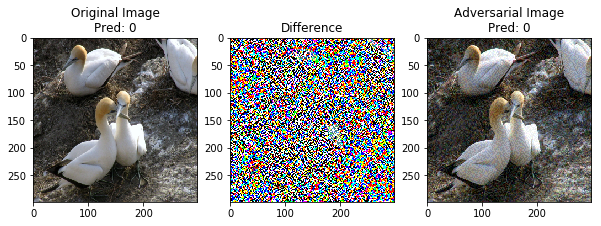

In [19]:
i = 0
plot_pair(x_test[i], adv[i], model=model2)